<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/dnn.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Training Deep Neural Networks
---
_homl3 ch11_

- A DNN has 10 and more layers
- each layer contains hundreds of neurons linked by hundreds of thousands of connections
- i.e. there are hundreds of thousands even millions of parameters


Problems in training DNNs
---
- gradients growing ever smaller or larger during backpropagating the DNN
  - called the `vanishing and exploding gradients` problems
  - both make lower layers very hard to train
- `insufficient data` for such a large DNN,
  - or it might be too costly to label, e.x. 
  - can be tackled with `transfer learning and unsupervised pretraining`
- A model with millions of parameters would severely risk `overfitting` the training set
  - especially if there are not enough training instances 
  - or if they are too noisy
  - can be tackled with `regularization techniques`
- Training may be extremely `slow`
  - can be tackled with various `optimizers` that can speed up training large models tremendously

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

import tensorflow as tf, keras_tuner as kt

import sys

/opt/micromamba/envs/ml/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# The Vanishing and Exploding Gradients Problems
- the backprop backward step propagates the error gradient from the output layer to the input layer
  - computes the gradient of the cost function with regard to each parameter in the network
  - then uses these gradients to update each parameter with a gradient descent step
- Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers
  - As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged
  - and training never converges to a good solution
  - This is called the `vanishing gradients problem`
- In some cases, the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges
  - This is the `exploding gradients problem`
  - often happens in recurrent neural networks
- More generally, DNNs suffer from `unstable gradients`
  - different layers may learn at widely different speeds

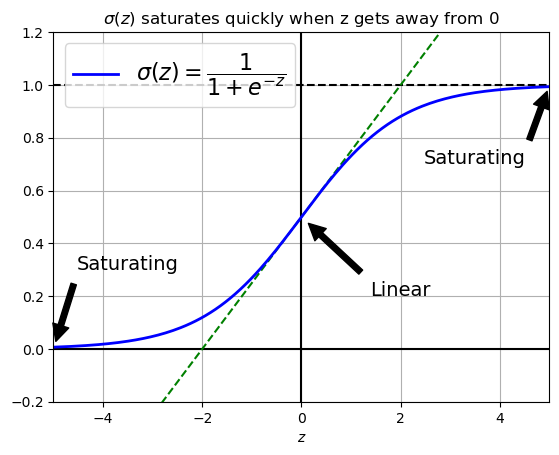

In [5]:
# 1. the sigmoid (logistic) activation function saturates quickly
#    when z gets away from 0 
#    i.e. the derivative gets very small

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

fig1, ax1 = plt.subplots()
ax1.plot([-5, 5], [0, 0], 'k-')
ax1.plot([-5, 5], [1, 1], 'k--')
ax1.plot([0, 0], [-0.2, 1.2], 'k-')
ax1.plot([-5, 5], [-3/4, 7/4], 'g--')
ax1.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
ax1.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
ax1.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
ax1.grid(True)
ax1.axis([-5, 5, -0.2, 1.2])
ax1.set_xlabel("$z$")
ax1.legend(loc="upper left", fontsize=16);
ax1.set_title(r"$\sigma(z)$" " saturates quickly when z gets away from 0");

Suspect caused the vanishing gradient problem
---
- the combination of sigmoid activation function and weight initialization technique ℕ(0,1)
  - causes the variance keeps increasing after each layer 
  - until the activation function saturates at the top layers
- this saturation is made worse due that 
  - the sigmoid function has a mean of 0.5, not 0
  - the hyperbolic tangent function has a mean of 0 
    - so it behaves slightly better than the sigmoid function
- ∴ there is almost no gradient to propagate back through the network
  - what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers
  - so there is really nothing left for the lower layers

Glorot Initialization 
---
when using the `sigmoid` activation function, `Glorot initialization` significantly 
- alleviates the unstable gradients problem
  - speeds up training considerably 
  - becomes one of the practices that led to the success of deep learning
- initializes the weights of each layer randomly with
  - normal distribution: ${\displaystyle N(0,σ^2)}$ where  ${\displaystyle σ^2=\frac{1}{\operatorname{fan}_{avg}}}$, or
  - uniform distribution: ${\displaystyle {\displaystyle {\mathcal {U}}_{[-r,r]}}}$ where ${\displaystyle r=\sqrt{\dfrac{3}{\operatorname{fan}_{avg}}}}$
  - ${\displaystyle \operatorname{fan}_{avg} = \dfrac{ \operatorname{fan}_{in}} {\operatorname{fan}_{out}}}$
  - the numbers of inputs and outputs of a layer are called the `fan-in` and `fan-out` of the layer
- `LeCun initialization` replaces $fan_{avg}$ with $fan_{in}$
  - equivalent to Glorot initialization when $fan_{in} = fan_{out}$

He Initialization 
---
- similar strategies have been proposed for different activation functions
  - they differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$
- The initialization strategy proposed for the `ReLU` activation function and its variants is called `He initialization` or `Kaiming initialization`
- Initialization parameters for each type of activation function

| Initialization |  Activation functions | σ² (Normal) |
|:--:|:--:|:--:|
| Glorot |  None, tanh, sigmoid, softmax |  $1 / fan_{avg}$ |
| He | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | $2 / fan_{in}$ |
| LeCun |  SELU | $1 / fan_{in}$ |
